In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
columns = ['unit_number', 'time_in_cycles', 'setting_1', 'setting_2', 'TRA', 'T2', 'T24', 'T30', 'T50', 'P2', 'P15', 'P30', 'Nf',
           'Nc', 'epr', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'farB', 'htBleed', 'Nf_dmd', 'PCNfR_dmd', 'W31', 'W32']

train_data_processed = []
for idx in range(1, 5):
    train_data = pd.read_csv(rf"/Users/hemant/Developer/Code/rul-prediction/CMaps/train_FD00{idx}.txt", sep=" ", header=None)
    train_data.drop(columns=[26, 27], inplace=True)  #Drop unnamed/NaN columns
    train_data.columns = columns
    train_data.drop(columns=['Nf_dmd', 'PCNfR_dmd', 'P2', 'T2', 'TRA', 'farB', 'epr'], inplace=True)  #irrelevant features
    
    # Calculate normalized 'used life fraction'
    train_data['RUL'] = train_data['time_in_cycles'] / train_data.groupby('unit_number')['time_in_cycles'].transform('max')
    
    train_data.drop(columns=['unit_number', 'setting_1', 'setting_2'], inplace=True)  #columns not contributing to prediction
    train_data_processed.append(train_data)
    print(f"Processed train_FD00{idx}.txt, number of rows: {train_data.shape[0]}")

train_data_processed = pd.concat(train_data_processed, ignore_index=True)

Processed train_FD001.txt, number of rows: 20631
Processed train_FD002.txt, number of rows: 53759
Processed train_FD003.txt, number of rows: 24720
Processed train_FD004.txt, number of rows: 61249


In [3]:
# Process test data from all 4 subsets (FD001-FD004)
test_data_processed = []
for idx in range(1, 5):
    test_data_rul = pd.read_csv(rf"/Users/hemant/Developer/Code/rul-prediction/CMaps/RUL_FD00{idx}.txt", sep=" ", header=None)
    test_data = pd.read_csv(rf"/Users/hemant/Developer/Code/rul-prediction/CMaps/test_FD00{idx}.txt", sep=" ", header=None)
    
    test_data.drop(columns=[26, 27], inplace=True)
    test_data.columns = columns
    test_data.drop(columns=['Nf_dmd', 'PCNfR_dmd', 'P2', 'T2', 'TRA', 'farB', 'epr'], inplace=True)
    
    # Calculate End-of-Life (EOL) by repeating true RUL for each unit's rows
    eol = []
    for un in test_data['unit_number'].unique():
        temp_data = test_data[test_data['unit_number'] == un]
        eol_temp = test_data_rul.iloc[un-1].values[0]
        eol_temp_list = [eol_temp for i in range(len(temp_data))]
        eol.extend(eol_temp_list)
    
    test_data['RUL'] = test_data['time_in_cycles'].values / (test_data.groupby('unit_number')['time_in_cycles'].transform('max').values + eol)
    test_data.drop(columns=['unit_number', 'setting_1', 'setting_2'], inplace=True)
    test_data_processed.append(test_data)
    print(f"Processed test_FD00{idx}.txt, number of rows: {test_data.shape[0]}")

# Concatenate all test subsets
test_data_processed = pd.concat(test_data_processed, ignore_index=True)

Processed test_FD001.txt, number of rows: 13096
Processed test_FD002.txt, number of rows: 33991
Processed test_FD003.txt, number of rows: 16596
Processed test_FD004.txt, number of rows: 41214


In [4]:
class RULDataset(Dataset):
    def __init__(self, dataframe):
        self.X = dataframe.drop(columns=["RUL"]).values.astype(np.float32)
        self.y = dataframe["RUL"].values.astype(np.float32).reshape(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])

In [5]:
# Multi Layered Perceptron
class RULModel(nn.Module):
    def __init__(self, input_dim):
        super(RULModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.model(x)

In [6]:
# Normalize the features
scaler = StandardScaler()
features = train_data_processed.drop(columns=['RUL'])
scaled_features = scaler.fit_transform(features)
train_data_processed.loc[:, features.columns] = scaled_features

# Normalize test data using same scaler
test_features = test_data_processed.drop(columns=['RUL'])
test_scaled_features = scaler.transform(test_features)
test_data_processed.loc[:, test_features.columns] = test_scaled_features

/var/folders/b9/t70zfk1x08s8zpstmgtlp03c0000gn/T/ipykernel_95073/2896835289.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.46438155 -1.45241094 -1.44044032 ...  1.55221385  1.56418447
  1.57615508]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_data_processed.loc[:, features.columns] = scaled_features
/var/folders/b9/t70zfk1x08s8zpstmgtlp03c0000gn/T/ipykernel_95073/2896835289.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1.00902172  1.00902172  0.94454996 ...  1.10572936 -0.76395171
 -0.89289524]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_data_processed.loc[:, features.columns] = scaled_features
/var/folders/b9/t70zfk1x08s8zpstmgtlp03c0000gn/T/ipykernel_95073/2896835289.py:10: FutureWarning: Setting an item of incompatible dtyp

In [7]:
dataset = RULDataset(train_data_processed)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

test_dataset = RULDataset(test_data_processed)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model instantiation
input_dim = train_data_processed.shape[1] - 1  # Number of features (exclude RUL)
model = RULModel(input_dim).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

In [8]:
# Function to evaluate model on test data
def evaluate_model(model, test_loader):
    model.eval()  # Switch to evaluation mode
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            all_preds.append(outputs.cpu().numpy())
            all_targets.append(y_batch.numpy())

    # Compute MSE
    preds = np.vstack(all_preds)
    targets = np.vstack(all_targets)
    mse = mean_squared_error(targets, preds)
    return mse

In [9]:
# Training loop with best model saving
best_mse = float("inf")
epochs = 20
for epoch in range(epochs):
    model.train()  # Switch to training mode
    running_loss = 0.0
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()  # Clear old gradients
        outputs = model(X_batch)  # Forward pass
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()  # Accumulate loss

    val_mse = evaluate_model(model, test_loader)  # Evaluate on test
    if val_mse < best_mse:
        best_mse = val_mse
        torch.save(model.state_dict(), "rul_ann_model.pth")

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(dataloader):.4f}, Test MSE: {val_mse:.4f}")

Epoch [1/20], Loss: 0.0081, Test MSE: 0.0061
Epoch [2/20], Loss: 0.0052, Test MSE: 0.0055
Epoch [3/20], Loss: 0.0051, Test MSE: 0.0057
Epoch [4/20], Loss: 0.0049, Test MSE: 0.0051
Epoch [5/20], Loss: 0.0048, Test MSE: 0.0055
Epoch [6/20], Loss: 0.0048, Test MSE: 0.0051
Epoch [7/20], Loss: 0.0047, Test MSE: 0.0052
Epoch [8/20], Loss: 0.0046, Test MSE: 0.0051
Epoch [9/20], Loss: 0.0046, Test MSE: 0.0052
Epoch [10/20], Loss: 0.0046, Test MSE: 0.0051
Epoch [11/20], Loss: 0.0046, Test MSE: 0.0051
Epoch [12/20], Loss: 0.0046, Test MSE: 0.0050
Epoch [13/20], Loss: 0.0045, Test MSE: 0.0053
Epoch [14/20], Loss: 0.0045, Test MSE: 0.0051
Epoch [15/20], Loss: 0.0045, Test MSE: 0.0050
Epoch [16/20], Loss: 0.0045, Test MSE: 0.0055
Epoch [17/20], Loss: 0.0045, Test MSE: 0.0051
Epoch [18/20], Loss: 0.0045, Test MSE: 0.0051
Epoch [19/20], Loss: 0.0044, Test MSE: 0.0053
Epoch [20/20], Loss: 0.0044, Test MSE: 0.0054


In [10]:
idx=1

test_data_rul = pd.read_csv(rf"/Users/hemant/Developer/Code/rul-prediction/CMaps/RUL_FD00{idx}.txt", sep=" ", header=None)
test_data = pd.read_csv(rf"/Users/hemant/Developer/Code/rul-prediction/CMaps/test_FD00{idx}.txt", sep=" ", header=None)


test_data.drop(columns=[26,27],inplace=True)
columns = ['unit_number','time_in_cycles','setting_1','setting_2','TRA','T2','T24','T30','T50','P2','P15','P30','Nf',
        'Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32' ]

test_data.columns = columns
test_data.drop(columns=['Nf_dmd','PCNfR_dmd','P2','T2','TRA','farB','epr'],inplace=True)

eol = []
for un in test_data['unit_number'].unique():
    temp_data = test_data[test_data['unit_number'] == un]
    eol_temp = test_data_rul.iloc[un-1].values[0]
    eol_temp_list = [eol_temp for i in range(len(temp_data))]

    eol.extend(eol_temp_list)


test_data['RUL'] = test_data['time_in_cycles'].values / (test_data.groupby('unit_number')['time_in_cycles'].transform('max').values + eol)

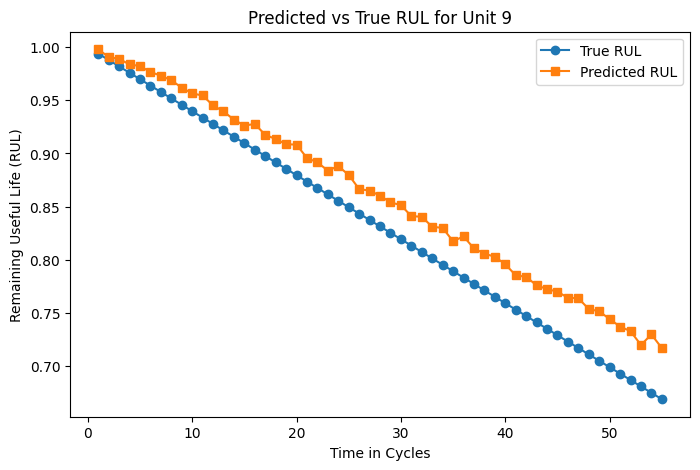

In [11]:
unit_id = 9  # Sample unit number
unit_data = test_data[test_data['unit_number'] == unit_id]
true_rul = unit_data['RUL'].values


X_batch = scaler.transform(unit_data.drop(columns=['unit_number','setting_1','setting_2','RUL']))
X_batch = torch.tensor(X_batch).float().to(device)
model.eval()
with torch.no_grad():
    pred_rul = model(X_batch).cpu().numpy().flatten()

plt.figure(figsize=(8, 5))
plt.plot(unit_data['time_in_cycles'], 1-true_rul, label='True RUL', marker='o')
plt.plot(unit_data['time_in_cycles'], 1-pred_rul, label='Predicted RUL', marker='s')
plt.xlabel('Time in Cycles')
plt.ylabel('Remaining Useful Life (RUL)')
plt.title(f'Predicted vs True RUL for Unit {unit_id}')
plt.legend()
plt.show()